## Setup: Import Libraries and Load Data

In [1]:
from huggingface_hub import snapshot_download
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from dosemetrics import Dose
from dosemetrics.io import load_structure_set
from dosemetrics.metrics import dvh, conformity, homogeneity, geometric

# Download and load the example dataset
data_path = Path(snapshot_download(
    repo_id="contouraid/dosemetrics-data",
    repo_type="dataset"
))

# Load test subject
subject_path = data_path / "longitudinal" / "time_point_1"
dose = Dose.from_nifti(subject_path / "Dose.nii.gz", name="Clinical")
structures = load_structure_set(subject_path)

print(f"✓ Loaded dose: {dose.shape}")
print(f"✓ Loaded {len(structures.structure_names)} structures")
print(f"\nAvailable structures:")
for i, name in enumerate(structures.structure_names):
    vol = structures.get_structure(name).volume_voxels()
    print(f"  {i+1}. {name:20s} (volume: {vol:.1f} cm³)")

/Users/amithkamath/Repositories/ContourAId/dosemetrics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 165 files: 100%|██████████| 165/165 [00:00<00:00, 525482.28it/s]


✓ Loaded dose: (128, 128, 128)
✓ Loaded 15 structures

Available structures:
  1. Pituitary            (volume: 106.0 cm³)
  2. OpticNerve_L         (volume: 63.0 cm³)
  3. Cochlea_R            (volume: 13.0 cm³)
  4. CTV                  (volume: 36435.0 cm³)
  5. OpticNerve_R         (volume: 82.0 cm³)
  6. Cochlea_L            (volume: 9.0 cm³)
  7. PTV                  (volume: 46058.0 cm³)
  8. LacrimalGland_L      (volume: 113.0 cm³)
  9. Eye_R                (volume: 898.0 cm³)
  10. LacrimalGland_R      (volume: 80.0 cm³)
  11. Chiasm               (volume: 79.0 cm³)
  12. GTV                  (volume: 2593.0 cm³)
  13. Brain                (volume: 134062.0 cm³)
  14. Eye_L                (volume: 955.0 cm³)
  15. Brainstem            (volume: 3152.0 cm³)


## 1. Dose-Volume Histograms (DVH)

The DVH is the fundamental metric in radiotherapy. It shows what percentage of a structure receives at least a given dose.

In [2]:
# Compute DVH for the target (PTV)
ptv = structures.get_structure("PTV")
dose_bins, volume_pcts = dvh.compute_dvh(dose, ptv)

print("PTV DVH computed:")
print(f"  Number of dose bins: {len(dose_bins)}")
print(f"  Dose range: {dose_bins[0]:.2f} - {dose_bins[-1]:.2f} Gy")
print(f"  Volume range: {volume_pcts.min():.1f}% - {volume_pcts.max():.1f}%")

# Extract key dosimetric parameters
stats = dvh.compute_dose_statistics(dose, ptv)

print("\nPTV Dose Statistics:")
print(f"  Mean dose:        {stats['mean_dose']:.2f} Gy")
print(f"  Max dose:         {stats['max_dose']:.2f} Gy")
print(f"  Min dose:         {stats['min_dose']:.2f} Gy")
print(f"  \n  Dose Coverage:")
print(f"    D98 (near-min):  {stats['D98']:.2f} Gy")
print(f"    D95 (standard):  {stats['D95']:.2f} Gy")
print(f"    D50 (median):    {stats['D50']:.2f} Gy")
print(f"    D02 (near-max):  {stats['D02']:.2f} Gy")

PTV DVH computed:
  Number of dose bins: 659
  Dose range: 0.00 - 65.80 Gy
  Volume range: 0.0% - 100.0%

PTV Dose Statistics:
  Mean dose:        60.15 Gy
  Max dose:         65.71 Gy
  Min dose:         48.60 Gy
  
  Dose Coverage:
    D98 (near-min):  56.57 Gy
    D95 (standard):  57.66 Gy
    D50 (median):    60.25 Gy
    D02 (near-max):  62.81 Gy


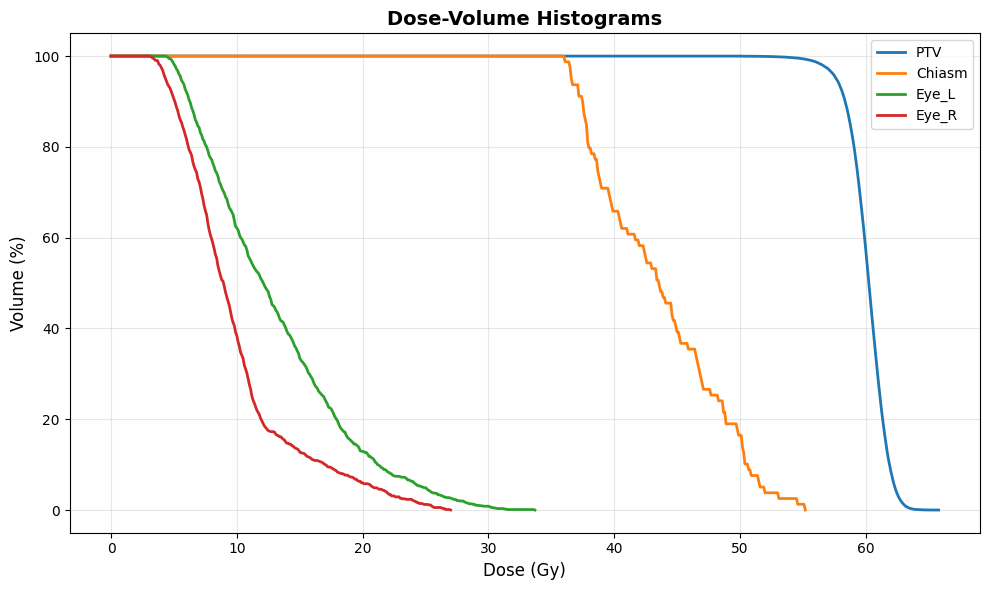

DVH plotted successfully


In [3]:
# Visualize DVH for multiple structures
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PTV
dose_bins, volume_pcts = dvh.compute_dvh(dose, ptv)
ax.plot(dose_bins, volume_pcts, linewidth=2, label="PTV")

# Plot OARs (organs at risk)
oar_names = ["BrainStem", "Chiasm", "Eye_L", "Eye_R"]
for oar_name in oar_names:
    if oar_name in structures:
        oar = structures.get_structure(oar_name)
        dose_bins, volume_pcts = dvh.compute_dvh(dose, oar)
        ax.plot(dose_bins, volume_pcts, linewidth=2, label=oar_name)

ax.set_xlabel("Dose (Gy)", fontsize=12)
ax.set_ylabel("Volume (%)", fontsize=12)
ax.set_title("Dose-Volume Histograms", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

print("DVH plotted successfully")

## 2. Conformity Indices

Conformity indices measure how well the high-dose region conforms to the target:
- **Coverage**: Fraction of target receiving prescription dose (should be ≈100%)
- **Spillage**: Fraction of high-dose volume outside target (should be minimal)
- **Conformity Index**: Combined measure of coverage and spillage

In [4]:
# Define prescription dose (typically around 70-79 Gy for brain tumors)
prescription_dose = 70.0  # Gy
high_dose_level = prescription_dose  # Gy

# Compute conformity metrics
coverage = conformity.compute_coverage(dose, ptv, high_dose_level)
print(f"Coverage (PTV volume receiving ≥{high_dose_level} Gy): {coverage:.1f}%")

# Note: spillage computation requires reference volume
# We'll compute spillage for the high-dose region
ci = conformity.compute_conformity_index(dose, ptv, high_dose_level)
print(f"Conformity Index: {ci:.3f}")

# Paddick Conformity Index (alternative definition)
pci = conformity.compute_paddick_conformity_index(dose, ptv, high_dose_level)
print(f"Paddick Conformity Index: {pci:.3f}")

# Conformity Number (fraction of target in high-dose region)
cn = conformity.compute_conformity_number(dose, ptv, high_dose_level)
print(f"Conformity Number: {cn:.3f}")

Coverage (PTV volume receiving ≥70.0 Gy): 0.0%
Conformity Index: 0.000
Paddick Conformity Index: 0.000
Conformity Number: 0.000


## 3. Homogeneity Indices

Homogeneity indices measure dose uniformity within the target:
- **Homogeneity Index**: Ratio of max to min dose (should be close to 1.0)
- **Gradient Index**: Measure of dose falloff outside target
- **Uniformity Index**: Alternative measure of dose uniformity

In [5]:
# Compute homogeneity metrics for PTV
hi = homogeneity.compute_homogeneity_index(dose, ptv)
print(f"Homogeneity Index (D05/D95): {hi:.3f}")
print(f"  → Ideal value: 1.0 (perfectly uniform)")
print(f"  → Acceptable: < 1.15 (most clinical plans)")

# Gradient Index (dose falloff)
gi = homogeneity.compute_gradient_index(dose, ptv, high_dose_level)
print(f"\nGradient Index: {gi:.3f}")
print(f"  → Measures dose falloff outside target")

# Dose Homogeneity (standard deviation approach)
dh = homogeneity.compute_dose_homogeneity(dose, ptv)
print(f"\nDose Homogeneity (std of dose): {dh:.2f} Gy")

# Uniformity Index
ui = homogeneity.compute_uniformity_index(dose, ptv)
print(f"Uniformity Index: {ui:.3f}")

Homogeneity Index (D05/D95): 0.103
  → Ideal value: 1.0 (perfectly uniform)
  → Acceptable: < 1.15 (most clinical plans)

Gradient Index: inf
  → Measures dose falloff outside target

Dose Homogeneity (std of dose): 0.02 Gy
Uniformity Index: 0.716


## 4. Geometric Metrics

Geometric metrics compare spatial overlap between structures (useful for comparing predictions vs ground truth):
- **Dice Coefficient**: Symmetric overlap metric (0-1 scale)
- **Jaccard Index**: IoU-style overlap metric
- **Volume metrics**: Differences and ratios
- **Sensitivity/Specificity**: Detection metrics

In [6]:
# For demonstration, we'll compare PTV with a dilated version
# (In practice, you'd compare predictions vs ground truth structures)

# Create a synthetic prediction by dilating the PTV
from scipy.ndimage import binary_dilation
from dosemetrics.structures import Target

ptv_mask = ptv.mask
# Dilate by ~3 pixels for demonstration
dilated_mask = binary_dilation(ptv_mask, iterations=3)
ptv_dilated = Target(name="PTV_Dilated", mask=dilated_mask)

# Compute geometric overlap metrics
dice = geometric.compute_dice_coefficient(ptv, ptv_dilated)
print(f"Dice Coefficient (PTV vs dilated PTV): {dice:.3f}")
print(f"  → 1.0 = perfect overlap")
print(f"  → 0.9+ = excellent (clinical-grade)")

jaccard = geometric.compute_jaccard_index(ptv, ptv_dilated)
print(f"\nJaccard Index: {jaccard:.3f}")
print(f"  → 1.0 = perfect overlap")

# Volume comparison
vol_diff = geometric.compute_volume_difference(ptv, ptv_dilated)
vol_ratio = geometric.compute_volume_ratio(ptv, ptv_dilated)
print(f"\nVolume Difference: {vol_diff:.1f} cm³")
print(f"Volume Ratio (PTV/PTV_Dilated): {vol_ratio:.3f}")

# Sensitivity (true positive rate) and Specificity
sensitivity = geometric.compute_sensitivity(ptv, ptv_dilated)
specificity = geometric.compute_specificity(ptv, ptv_dilated)
print(f"\nSensitivity (recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

Dice Coefficient (PTV vs dilated PTV): 0.772
  → 1.0 = perfect overlap
  → 0.9+ = excellent (clinical-grade)

Jaccard Index: 0.629
  → 1.0 = perfect overlap

Volume Difference: 295.2 cm³
Volume Ratio (PTV/PTV_Dilated): 5.029

Sensitivity (recall): 0.629
Specificity: 1.000


## 5. Equivalent Uniform Dose (EUD)

EUD is the uniform dose that would deliver the same biological effect as the actual non-uniform dose distribution.
It's useful for comparing different dose distributions and predicting clinical outcomes.

In [7]:
# Compute EUD for different tissues
# For tumors, use negative a-value (lower dose is worse)
# For OARs, use positive a-value (higher dose is worse)

# EUD for target (tumor control probability sensitive structure)
eud_target = dvh.compute_equivalent_uniform_dose(dose, ptv, a_parameter=-10)
print(f"EUD for PTV (a=-10): {eud_target:.2f} Gy")
print(f"  → Negative a-value: tumor control sensitivity")
print(f"  → Compare with mean dose: {stats['mean_dose']:.2f} Gy")

# EUD for critical organs (normal tissue complication probability sensitive)
print(f"\nEUD for Organs at Risk (a=3):")
for oar_name in ["BrainStem", "Chiasm", "Eye_L"]:
    if oar_name in structures:
        oar = structures.get_structure(oar_name)
        eud_oar = dvh.compute_equivalent_uniform_dose(dose, oar, a_parameter=3)
        stats_oar = dvh.compute_dose_statistics(dose, oar)
        print(f"  {oar_name:15s}: EUD={eud_oar:.2f} Gy, Mean={stats_oar['mean_dose']:.2f} Gy")

EUD for PTV (a=-10): 59.92 Gy
  → Negative a-value: tumor control sensitivity
  → Compare with mean dose: 60.15 Gy

EUD for Organs at Risk (a=3):
  Chiasm         : EUD=44.30 Gy, Mean=43.69 Gy
  Eye_L          : EUD=15.54 Gy, Mean=13.06 Gy


## 6. Clinical Constraints Checking

Verify that the dose plan meets clinical constraints.

In [8]:
# Define clinical constraints
constraints = {
    "PTV": {
        "min_D95": 66.5,  # At least 95% of target receives ≥66.5 Gy
        "max_D02": 79.0,  # No more than 2% of target exceeds 79 Gy
    },
    "BrainStem": {
        "max_D0.1": 54.0,  # Max dose to 0.1% should be < 54 Gy
    },
    "Chiasm": {
        "max_D0.1": 54.0,  # Max dose to 0.1% should be < 54 Gy
    },
}

# Check constraints
print("Constraint Verification:")
print("=" * 60)

# Target constraints
ptv_stats = dvh.compute_dose_statistics(dose, ptv)
print(f"\nPTV:")
d95_pass = ptv_stats['D95'] >= constraints["PTV"]["min_D95"]
print(f"  D95 constraint (≥{constraints['PTV']['min_D95']:.1f} Gy): ", end="")
print(f"{'✓ PASS' if d95_pass else '✗ FAIL'} (actual: {ptv_stats['D95']:.2f} Gy)")

d02_pass = ptv_stats['D02'] <= constraints["PTV"]["max_D02"]
print(f"  D02 constraint (≤{constraints['PTV']['max_D02']:.1f} Gy): ", end="")
print(f"{'✓ PASS' if d02_pass else '✗ FAIL'} (actual: {ptv_stats['D02']:.2f} Gy)")

# OAR constraints
for oar_name in ["BrainStem", "Chiasm"]:
    if oar_name in structures:
        oar = structures.get_structure(oar_name)
        oar_stats = dvh.compute_dose_statistics(dose, oar)
        print(f"\n{oar_name}:")
        
        # Use D02 as proxy for max dose to small volume
        max_constraint = constraints[oar_name]["max_D0.1"]
        d02_oar = oar_stats['D02']
        d02_pass = d02_oar <= max_constraint
        print(f"  D0.1 constraint (≤{max_constraint:.1f} Gy): ", end="")
        print(f"{'✓ PASS' if d02_pass else '✗ FAIL'} (actual: {d02_oar:.2f} Gy)")

Constraint Verification:

PTV:
  D95 constraint (≥66.5 Gy): ✗ FAIL (actual: 57.66 Gy)
  D02 constraint (≤79.0 Gy): ✓ PASS (actual: 62.81 Gy)

Chiasm:
  D0.1 constraint (≤54.0 Gy): ✓ PASS (actual: 53.69 Gy)


## Summary

This notebook demonstrated the key dosimetric metrics in radiotherapy planning:

1. **DVH Analysis**: Understanding dose distributions and extracting key parameters
2. **Conformity**: Measuring coverage and spillage
3. **Homogeneity**: Assessing dose uniformity
4. **Geometric Metrics**: Comparing structure overlap
5. **EUD**: Computing equivalent uniform dose
6. **Constraint Checking**: Verifying plan acceptability

For more information, see the [API documentation](../api/metrics.md).